# Data Exploration and Preprocessing



In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.layers import Normalization, RandomFlip, RandomRotation, RandomZoom
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In order to be sure all images are the same size I resized them to 128 by 128. The dataset claimed all images were already sized, however I decided it makes sense to be sure.

In [35]:
# Load in paths
train_dir = "/content/drive/MyDrive/Colab Notebooks/Final Project/machine-learning-final/PandasBears/Test"
test_dir = "/content/drive/MyDrive/Colab Notebooks/Final Project/machine-learning-final/PandasBears/Train"

img_size = 128    # Image resize for more managable
batch_size = 32   # Number of images per batch

# Load in training dataset
train = tf. keras.preprocessing.image_dataset_from_directory(
            train_dir,
            image_size=(img_size, img_size),
            shuffle=True,
            batch_size=batch_size)

# Load in testing dataset
test = tf. keras.preprocessing.image_dataset_from_directory(
            test_dir,
            image_size=(img_size, img_size),
            shuffle=True,
            batch_size=batch_size)

Found 100 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


The PandasBears dataset contains 640 images in 2 classes. The data is first split by training and testing data with 128 training images and 512 testing images.

In [36]:
# Get the total number of images and classes
num_classes = len(train.class_names)
class_names = train.class_names

total_training_images = tf.data.experimental.cardinality(train).numpy() * batch_size  # Total images in training dataset
total_testing_images = tf.data.experimental.cardinality(test).numpy() * batch_size  # Total images in testing dataset
total_images = total_training_images + total_testing_images  # Total images in dataset

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}\n")
print(f"Total training images: {total_training_images}")
print(f"Total testing images: {total_testing_images}")
print(f"Total images: {total_images}")

Number of classes: 2
Class names: ['Bears', 'Pandas']

Total training images: 128
Total testing images: 512
Total images: 640


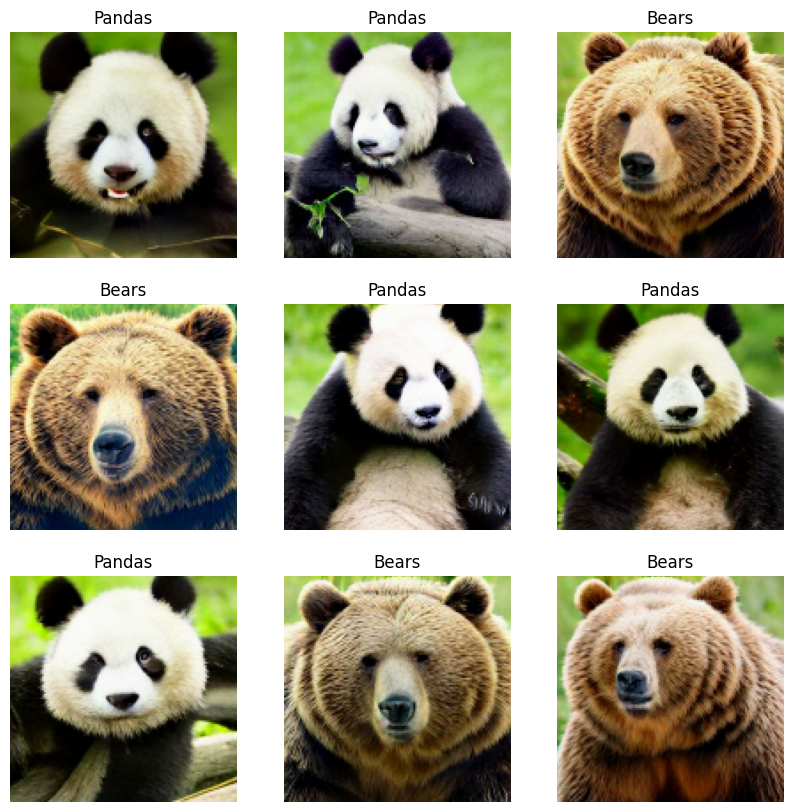

In [37]:
# Display a few sample images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train.class_names[labels[i]])
        plt.axis("off")
plt.show()

The distribution of pandas vs bears is a perfect split of 50 - 50. This means 64 each in the training and 256 each in the testing. Since there is no imbalance in my dataset I do not need to worry about frequency of images causing underfitting or overfitting.


In [38]:
# Get the class distribution (number of images per class)
class_counts = {}
for images, labels in train:
    for label in labels.numpy():
        class_counts[train.class_names[label]] = class_counts.get(train.class_names[label], 0) + 1

print("Class Distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Class Distribution:
Pandas: 50
Bears: 50


Checking for missing or corrupted images showed no corrupted images for either dataset. I did this by attempting to load each image, if it doesn't load it is corrupted.


In [39]:
def check_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()  # Verify that the image is not corrupted
        return True
    except (IOError, SyntaxError) as e:
        print(f"Corrupted image file: {file_path}")
        return False

# Testing the train set
for root, dirs, files in os.walk(train_dir):
    for file in files:
        file_path = os.path.join(root, file)
        check_image(file_path)

# Testing the test set
for root, dirs, files in os.walk(test_dir):
    for file in files:
        file_path = os.path.join(root, file)
        check_image(file_path)


On average the brighness of our images are dark, but not extremely. Our mean pixel value of 101.7 indicates this, with values ranging from 0 (black) to 255 (white) it is evident our pictures are more black than white.

The standard deviation of 81.17 measures the spread/variation of pixel values around the mean. 81.17 suggests there is a significant amount of variation in the pixel values so our images have a decent amount of contrast and detail.

In [40]:
# Calculate and display some basic image statistics (mean, standard deviation)
image_list = []
for images, labels in train:
    for image in images.numpy():
        image_list.append(image)

all_images = np.array(image_list)

# Average brightness or intesisty of the images
print(f"Mean pixel value: {np.mean(all_images)}")

# Variations of spread pixel values around the mean, higher = more contrast and variation
print(f"Standard deviation of pixel values: {np.std(all_images)}")

# Store these values in variables
mean_pixel_value = np.mean(all_images)
std_pixel_value = np.std(all_images)

Mean pixel value: 101.693115234375
Standard deviation of pixel values: 81.1673583984375


It is a common technique to use the mean and standard deviation values to normalize a dataset. To do this I use the same values for both the training and testing dataset to ensure consistency. Normalization can significantly improve the performance of my model. The normilization being added to the model is not shown here as it is best to use it as a layer in our model. For example, I will do something like below:

```
# Build your model
model = tf.keras.Sequential([
    normalization_layer,  # Add the normalization layer as the first layer
    # .. the rest of the layers
])

```
First I need to specify my layer though, this is shown below.

In [41]:
# Create a Normalization layer
normalization_layer = Normalization()

# Adapt the layer to your data
normalization_layer.adapt(train.map(lambda x, _: x))

I will also add a layer for data augmentation. This will expand the diversity of my dataset by applying various transformations. Since our dataset size is not very large (as discussed above), this is an important step in providing the model with more examples to learn from. It also reduces the models chances of overfitting and increases models robustness. This step will hoepfully make the model have better performance.

In [42]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),  # Flips images horizontally
    RandomRotation(0.2),  # Rotates images by up to 20%
    RandomZoom(0.2),  # Zooms images by up to 20%
])

The step below optimizes the data pipeline. The `cache()` operation caches this dataset in memory so it can be loaded faster. The `shuffle()` operation shuffles the elements using a buffer of the specified size, this helps with randomixation. The `prefetch()` operation fetches the elements of the datset in the background.

In [43]:
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Selection & Training

The machine learning algorithm I have chosen for my Image Classification task is called Convolutional Neural Network (CNN). This algorithm allows the model to understand the features of the image with foresigh and remember the features in order to guess the class of image.

**What is a Convolutional Neural Network?**

They are similiar to normal neural networks like we discused in class expect that they are designed for an input of grid-like data or images. CNN's also automatically learn hierachical features from the input image through their layers. Another important feature is *weight sharing*, CNN's apply the same filter across different parts of an image reducing the parameters and making the model more efficient.

They are made up of 3 main types of layers:

1. Convolutional Layer
  - core building block, does most of the computational heavy lifting
  - a series of learnable filters that slide across the image and perform element-wise mutliplications and summations to produce feature maps
2. Pooling Layer
  - reduce the spatial deminsions of the feature maps
  - reduce the amount of paramaeters and computation in the network -> control overfitting
  - makes the network less sensitive to minor variations in the input
3. Fully Connected Layer
  - connect all neurons in one layer to all neurons in the next layer
  - used to learn complex relationships between features and make predictions

These layers are stacked to form a full ConvNet architecture.

For more information:

https://cs231n.github.io/convolutional-networks/  


https://www.geeksforgeeks.org/image-classifier-using-cnn/


The ConvNet architecture layering pattern I have chosen is `INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL]*3 -> [FC -> RELU]*2 -> FC`. It is made up of two CONV (convolutional) layers stacked before every pool layer. This is because CONV layers can help to develop more complex features. In total we have 3 blocks of CONV POOl layers and we end with the FC (fully connected) layers.

In [69]:
model = tf.keras.models.Sequential([
    # Input layer (Assuming input shape is (img_size, img_size, 3))
    tf.keras.layers.Input(shape=(img_size, img_size, 3)),

    # Data Augmentation Layer (created in `Data Exploration`)
    data_augmentation,

    # Normilization Layer (created in `Data Exploration`)
    normalization_layer,

    # [CONV -> RELU -> CONV -> RELU -> POOL]*3 block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Adding Dropout to Convolutional Layers
    tf.keras.layers.Dropout(0.15),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Adding Dropout to Convolutional Layers
    tf.keras.layers.Dropout(0.15),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # [FC -> RELU]*2 block
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.25), # Adding L2 Regularization and Dropout to Dense Layers

    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.25), # Adding L2 Regularization and Dropout to Dense Layers

    # Final FC layer (Output layer)
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


As seen above there are comments that say `Adding Dropout` or `Adding L2 Regularization`, this is because in order to try to continue improving my model I implemented regularization techniques.
> **L1 and L2 Regularization** adds penatlty terms to the loss function and discorage large weights in the model. **L1** encourages sparsity and **L2** encourages smaller weights overall.

> **Dropout** randomly sets a fraction of input units to 0 at each update during training in an effort to prevent overfitting by reducing interdependence between neurons.

After one run with this improvement I saw a decrease in performance so I lowered the regularizer from `0.01` to `0.001` and decreased the dropout of the dense layers from `0.5` to `0.25` and the dropout of conv layers from `0.25` to `0.15`.

In [70]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
  )

After the first run of my model I noticed there could be potential overfitting due to the training accuracy being slightly higher than the validation accuracy on epochs 5 and 7. In order to work on combatting this I decided to implement early stopping.

In [71]:
early_stopping = EarlyStopping(
  monitor='val_loss',  # Metric to monitor (e.g., validation loss)
  patience=3,          # Number of epochs with no improvement before stopping
  restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [72]:
epochs = 9  # Number of training epochs
history = model.fit(
  train,
  verbose=1,
  validation_data=test,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/9
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 8s/step - accuracy: 0.6168 - loss: 1.1522 - val_accuracy: 0.5000 - val_loss: 1.0088
Epoch 2/9
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 9s/step - accuracy: 0.5413 - loss: 1.0733 - val_accuracy: 0.9080 - val_loss: 0.9920
Epoch 3/9
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 9s/step - accuracy: 0.6968 - loss: 1.0094 - val_accuracy: 0.9200 - val_loss: 0.8921
Epoch 4/9
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 9s/step - accuracy: 0.9214 - loss: 0.8361 - val_accuracy: 0.9980 - val_loss: 0.5296
Epoch 5/9
4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 10s/step - accuracy: 0.9175 - loss: 0.5612 - val_accuracy: 0.9980 - val_loss: 0.3190
Epoch 6/9
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 8s/step - accuracy: 0.9406 - loss: 0.4658 - val_accuracy: 1.0000 - val_loss: 0.3032
Epoch 7/9
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 9s/step - accuracy: 0.9396 - loss: 0.5465 - val_accuracy: 0.9940 - val_loss: 0.2991
Epoch 8/9
4/4 ━━━━━━━━━━━━━━━━━━━━ 44s 10s/step - accuracy: 0.9594 - loss: 0.4451 - val_accuracy: 0.9920 - val_loss: 0.2947
Epoch 9/9
4/4 

In [73]:
test_loss, test_acc = model.evaluate(test, verbose=2)
print('\nTest accuracy:', test_acc)
print('Test loss:', test_loss)

16/16 - 17s - 1s/step - accuracy: 0.9920 - loss: 0.2947

Test accuracy: 0.9919999837875366
Test loss: 0.29465895891189575


To test for overfitting and underfitting I use the code below. If the training accurancy is significantly higher than the valdiation accuracy the model is likely overfitting and memorizing the training data. If the training and validation accuracy are both low it suggests the model is underfitting, and is not complex enough to learn the patterns in the image data.

In [74]:
# Print training and validation accuracy
print("Training accuracy:", history.history['accuracy'])
print("Validation accuracy:", history.history['val_accuracy'])

Training accuracy: [0.6000000238418579, 0.5600000023841858, 0.5799999833106995, 0.8899999856948853, 0.8999999761581421, 0.9399999976158142, 0.9300000071525574, 0.949999988079071, 0.9300000071525574]
Validation accuracy: [0.5, 0.9079999923706055, 0.9200000166893005, 0.9980000257492065, 0.9980000257492065, 1.0, 0.9940000176429749, 0.9919999837875366, 0.9900000095367432]


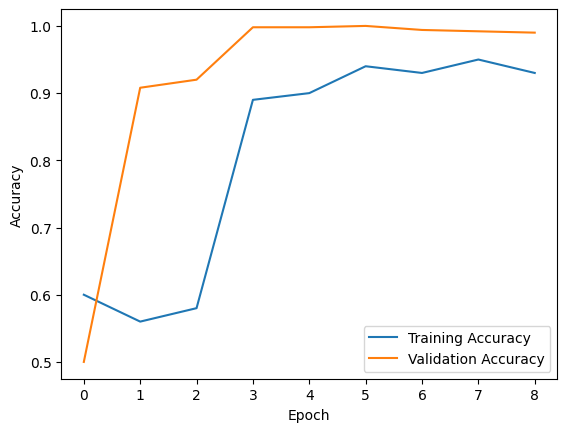

In [75]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

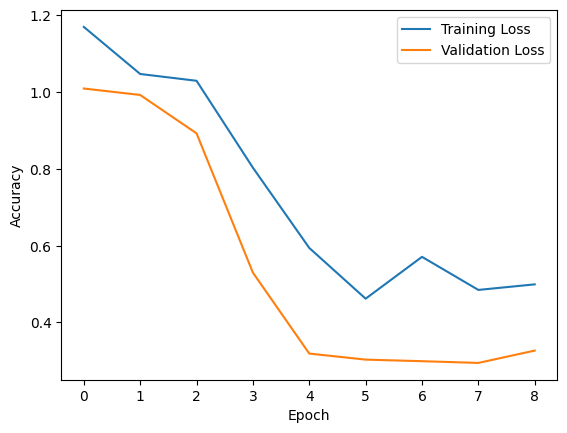

In [76]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

After applying improvements my models accuracy improved and is more stable with redued overfitting.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step
Image Prediction 
Actual label:  Bears
Predicted label:  Bears


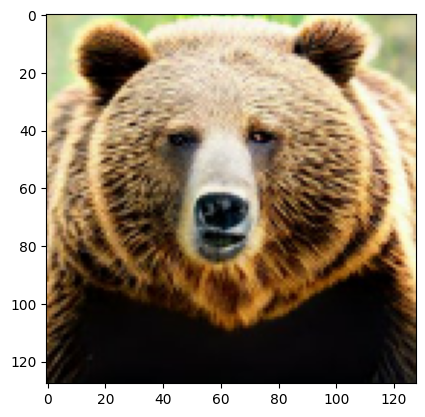

In [84]:
for img_batch, labels_batch in test.take(1):

    first_img = img_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    plt.imshow(first_img)

    batch_prediction = model.predict(img_batch)

    print('Image Prediction ')
    print('Actual label: ', class_names[first_label])
    print('Predicted label: ',class_names[np.argmax(batch_prediction[0])])


Below we can see a visualization of the model's confidence in predicting images. It is pretty high indicating strong predictions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


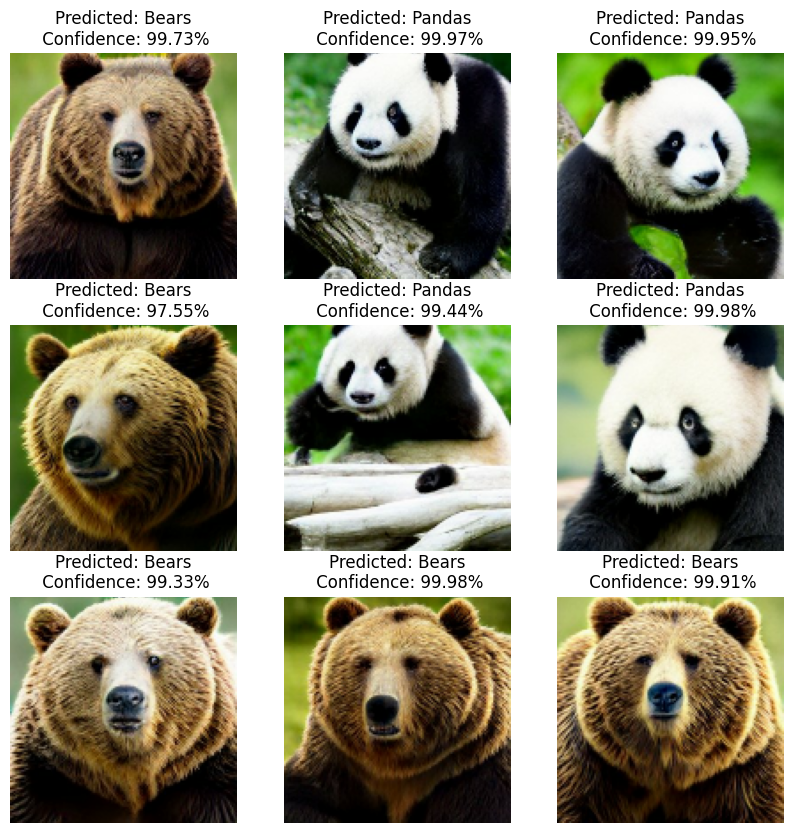

In [93]:
# Assuming 'test' is your test dataset and 'class_names' are defined
for images, labels in test.take(1):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    predicted_probabilities = np.max(predictions, axis=1)

    # Display images with predictions and confidence scores
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display the first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        confidence_percentage = predicted_probabilities[i] * 100  # Convert to percentage
        plt.title(f"Predicted: {class_names[predicted_labels[i]]}\n Confidence: {confidence_percentage:.2f}%")
        plt.axis("off")
    plt.show()
    break  # Exit the loop after processing one batch

To evaluate my model I chose to use the F1-score primarly. This is because it is a combination of both precision and recall. I chose this because of the datasets characterisitics (balanced classes and binary classification).

In [95]:
from sklearn.metrics import f1_score

y_pred = model.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
y_true = np.concatenate([y for x, y in test], axis=0)  # Get true labels from the test set

f1 = f1_score(y_true, y_pred_classes, average='binary')
print(f"F1-score for panda class: {f1}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step
F1-score for panda class: 0.5198412698412699


In [97]:
from sklearn.metrics import classification_report

# Assuming 'y_true' and 'y_pred_classes' are defined as before
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       Bears       0.52      0.51      0.51       250
      Pandas       0.52      0.52      0.52       250

    accuracy                           0.52       500
   macro avg       0.52      0.52      0.52       500
weighted avg       0.52      0.52      0.52       500



In [99]:
model.save('pandasBears1.keras')

I use the summary and plot_model features to show a represntation of how my models layers work. We see a the overall structure, types of layers, how they are connected, and the number of parameters.

In [100]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_1 (Normalization)      │ (None, 128, 128, 3)         │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,494,639 (51.48 MB)

 Trainable params: 4,498,210 (17.16 MB)

 Non-trainable params: 7 (32.00 B)

 Optimizer params: 8,996,422 (34.32 MB)

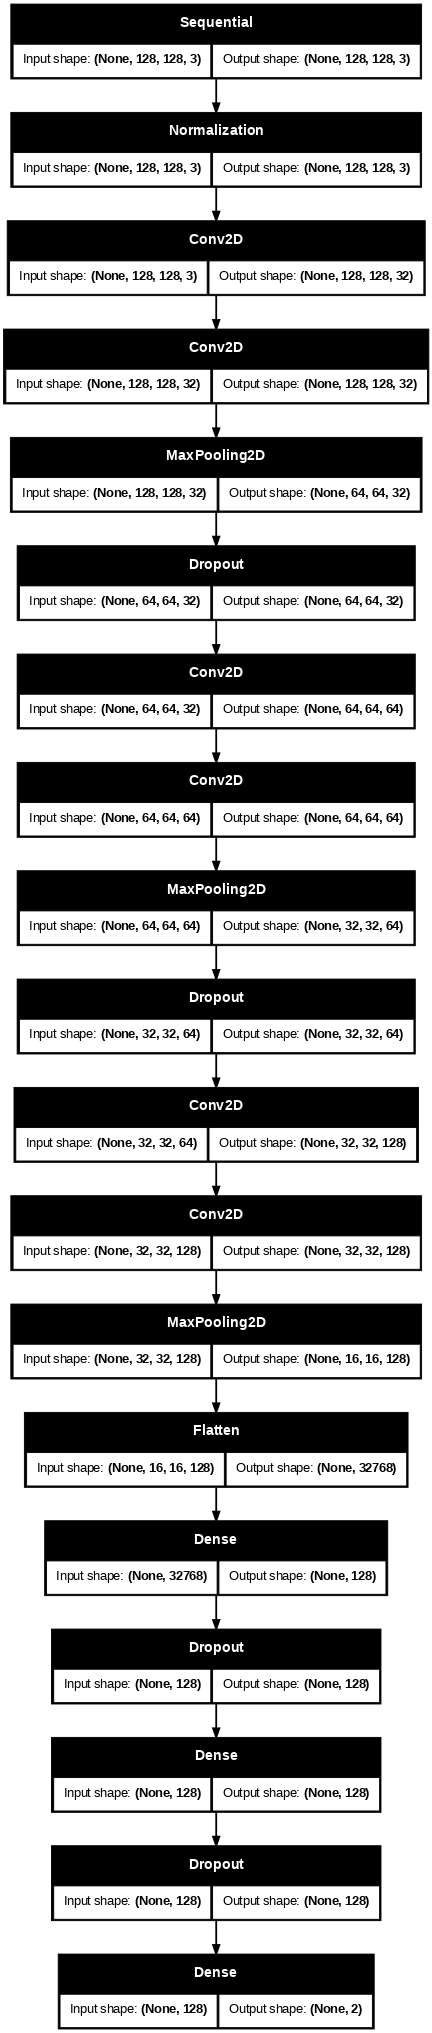

In [111]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, dpi=65)